# Raylight Analysys

In this notebook we will study light reflaction ans refraction, using raylight analysis and the Snell and Fresnel equations.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Create a the a raylight graph class

In [2]:
class Raylight:
    """Defines a raylight vecto"""
    def __init__(self, r_type:int, angle_deg:int): 
        """ Intialize a raylight vector

            Args:
                type: int
                    Ray r_type -> 0 = Inciddent, 1 = Reflected and 2 = Refracted
                angle: float
                    Angle from the normal in degrees
            
            Returns: Raylight object
        """
        self.type = r_type
        self.angle = angle_deg
        self.polarization = 'p'


class Material:
    """Material with properties related to light interaction"""
    
    def __init__(self, name:str,  refractive_index:str, thickness_mm:float):
        """ Intialize a Material

            Args:
                type: int
                    Ray r_type -> 0 = Inciddent, 1 = Reflected and 2 = Refracted
                angle: float
                    Angle from the normal in degrees
            
            Returns: Material object
        """
        self.name = name
        self.refractive_index = refractive_index
        self.thickness = thickness_mm


class RaylightGraph:
    """ Raylight graph for multiple interfaces"""

    def __init__(self):
        self.figure, self.axis = plt.subplots()
    
    def __init__(self, hight: int, width: int):
        self.figure, self.axis = plt.subplots()
        self.axis.set_ylim(-hight, 0.1*hight)
        self.axis.set_xlim(-width//2, width//2)

    def plot_vector(self, vector:list = [(0, 0),(0, 0)]):
        a = vector[0]
        b = vector[1]
        dx = b[0] - a[0]
        dy = b[1] - a[1]

        vec_ab_magnitude = math.sqrt(dx**2+dy**2)
        head_length = vec_ab_magnitude * 0.05

        dx = dx / vec_ab_magnitude
        dy = dy / vec_ab_magnitude

        vec_ab_magnitude = vec_ab_magnitude - head_length

        self.axis.arrow(a[0], a[1], vec_ab_magnitude*dx, vec_ab_magnitude*dy, 
                        head_width=0.5*head_length, head_length=head_length, 
                        color='blue')
        
        
    def show(self):
        plt.show()


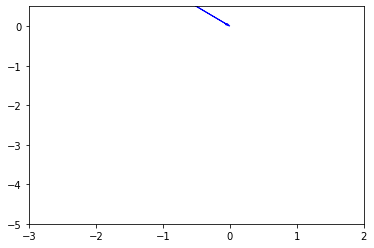

In [3]:
rayligh_graph = RaylightGraph(5,5)

rayligh_graph.plot_vector([(-1, 1),(0, 0)])
rayligh_graph.show()